#   John Downing IS71068A Assignment 1

In [1]:
# Imports and directives
import calendar
import math
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import sys
from decimal import Decimal
%matplotlib inline

In [2]:
# Library versions, for info
print ('Developed with the following library versions:')
print ('Python:\t\t\x1b[34m%s\x1b[0m' % (sys.version))
print ('Matplotlib:\t\x1b[34m%s\x1b[0m' % (matplotlib.__version__))
print ('Numpy:\t\t\x1b[34m%s\x1b[0m' % (np.version.version))
print ('Pandas:\t\t\x1b[34m%s\x1b[0m' % (pd.__version__))

Developed with the following library versions:
Python:		2.7.11 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:58:36) [MSC v.1500 64 bit (AMD64)]
Matplotlib:	1.5.1
Numpy:		1.10.4
Pandas:		0.18.0


In [3]:
# Top level declarations
listings_file_name = 'listings.london.csv'
calendar_file_name = 'calendar.london.csv.gz'
random_seed = 0 #so can reproduce results

## Part A

1\. Import the listings.csv data into your notebook.

In [4]:
# Only reading the columns we care about, for simplicity
usecols = [
    'id',
    'name',
    'neighbourhood',
    'room_type',
    'price',
    'minimum_nights',
    'latitude', 
    'longitude'
]

# Read the file
listings = pd.read_csv(listings_file_name, usecols=usecols)

# Output some info for sanity check
print ('missing values? %s' %(listings.isnull().values.any()))
print ('shape: %s' % (str(listings.shape)))
print ('dtypes:\n%s' % (str(listings.dtypes)))

missing values? False
shape: (42646, 8)
dtypes:
id                  int64
name               object
neighbourhood      object
latitude          float64
longitude         float64
room_type          object
price               int64
minimum_nights      int64
dtype: object


2\. How many listings are there in your city? 

In [5]:
print('Number of listings:\t%d' % (len(listings)))

Number of listings:	42646


3\. What is the minimum and maximum price?

In [6]:
# Obviously these are taken from the listings.csv file, rather than the
# prices/night column in the calendar file.
print('Min nightly price:\t$%.2f' % (listings['price'].min()))
print('Max nightly price:\t$%.2f' % (listings['price'].max()))

Min nightly price:	$7.00
Max nightly price:	$7001.00


4\. Which listing has the maximum number of minimum_nights stay? 

In [7]:
# Determine the max value of 'minimum_nights'
longest_minimum_stay = listings['minimum_nights'].max()

# Now print any listings with that value. Of course
# there may be more than one.
print ('Listing(s) with longest minimum stay:')
listings[listings['minimum_nights']==longest_minimum_stay]

Listing(s) with longest minimum stay:


,id,name,neighbourhood,latitude,longitude,room_type,price,minimum_nights
30017,9934901,Brick Lane area,Tower Hamlets,51.524902,-0.071612,Entire home/apt,100,1000


5\. What are the different room types offered by your city?

In [8]:
# print each on new line as we don't know how many there are
print('Available Room Types:')
for room_type in sorted(listings['room_type'].unique()): print ('%s' % (room_type)) 

Available Room Types:
Entire home/apt
Private room
Shared room


## Part B

i\. Import the calendar data into your notebook.

In [9]:
# Am doing datatype conversion for price on the fly, since 
# pandas is otherwise hell bent on using floats (NaN) for 
# missing values - despite price being a str column. Any provided 
# fill value e.g.'$0.00' seems to get silently ignored, so am 
# just converting everything to float up front.In any event, 
# this way is probably faster.

regexp = re.compile('[$,]') # assumes fixed price format, obvs

def priceConverter(price):
    priceStr = str(price)
    # Strictly speaking we might want to use Decimal here, since we're
    # representing monetary amounts. However that means we end up with 
    # Series dtype 'object', which is hideously slow to aggregate later.
    return None if priceStr == '' else float(re.sub(regexp, '', price))

# dict of converters to pass into read_csv
converters = {
    'price' : priceConverter
}

# dict of data types to pass into read_csv
dtype = {
    'listing_id': int,
    # See notes above regards parsing price directly to float
    'price' : float,
    # Note that we can't specify 'date':np.datetime64 here, 
    # the interpreter forces use of "parse_dates" instead.
    'date' : str, 
    # Note am also converting directly to bool rather than 'f' or 't'
    'available' : bool
}

# Now we can actually read the file..
listings_calendar = pd.read_csv(
    calendar_file_name, 
    converters = converters, #converting price directly to float (see above)
    dtype = dtype,
    usecols = dtype.keys(),
    true_values = ['t'], #converting t/f directly to bool values
    false_values = ['f'], #converting t/f directly to bool values
    parse_dates = ['date'] #converting date directly to datetime64
)

# ..and output some info for sanity check
missing_values = listings_calendar.isnull().values.any()
if missing_values:
    for column in listings_calendar.columns.values.tolist():
        print ('missing values [%s]? %s' %(column, listings_calendar[column].isnull().values.any()))
else:
    print ('missing values? False')
print ('shape: %s' % (str(listings_calendar.shape)))
print ('dtypes:\n%s' % (str(listings_calendar.dtypes)))

missing values [listing_id]? False
missing values [date]? False
missing values [available]? False
missing values [price]? True
shape: (15565790, 4)
dtypes:
listing_id             int32
date          datetime64[ns]
available               bool
price                float64
dtype: object


ii\.  Select one random property that has at least 5 bookings.

In [10]:
# Note that some of the listings are unavailable all year, so 'available==False' does not
# necessarily mean booked (unless these properties are actually booked 365 days, which 
# seems unlikely). We could remove these from dataframe(s), but for the sake of a quiet life..

# For example, this is one that doesn't have any availability all year
print (listings.ix[30205])
print ('any nights available?: %s' % (
    listings_calendar[listings_calendar.listing_id == 12431023].available.unique()))

# Also note that I'm not doing anything about the missing values in the 'price' column,
# since these are by design e.g. we don't get a price where 'available' is False. We 
# could backfill these with the mean price per listing, but this wouldn't change our later
# calculations (well, it wouldn't change the mean; it may skew our std dev) and in any event 
# Pandas is designed to handle the NaNs for us.

id                                           12431023
name              Double bedroom with shared bathroom
neighbourhood                           Tower Hamlets
latitude                                      51.5258
longitude                                  -0.0720409
room_type                                Private room
price                                              60
minimum_nights                                      1
Name: 30205, dtype: object
any nights available?: [False]


In [11]:
# Anyways, on to selecting a random property with at least 5 bookings. 
# I'm doing this programatically rather than eyeballing the data.

# Select all dates with bookings (ie. dates that are unavailable)
bookings = listings_calendar[listings_calendar['available'] == False]

# Group them by listing and aggregate to get count per listing
bookings_per_listing = bookings[['listing_id', 'date']].groupby(
    'listing_id', as_index=False).count()

# Bit of housekeeping (rename the aggregate column to 'num_bookings')    
bookings_per_listing.rename(columns={'date':'num_bookings'}, inplace=True)

# Now select all listings with at least 5 dates booked
at_least_five_bookings = bookings_per_listing[
    bookings_per_listing['num_bookings'] >= 5]

# Set random seed, for the purposes of being able to recreate/debug/demo findings
random.seed(random_seed)

# Pick a random row with at least five bookings (could alternatively use pd.sample)
random_index = random.randint(0, len(at_least_five_bookings)-1)

# Reset to true (pseudo)random to avoid side effects later
random.seed(None)

# And finally determine the ilsting id for our randomly chosen row
random_index_id = listings_calendar.ix[random_index]['listing_id']
print ('Selected listing: #%s' %(random_index_id))

Selected listing: #9696223


1\. List the dates that have been booked. How many dates have been booked vs not booked.

In [12]:
# Find all dates in the calendar for our chosen listing
listing_dates = listings_calendar[listings_calendar['listing_id'] == random_index_id]

# Find those dates which are booked (unavailable)
listing_dates_booked = listing_dates[-listing_dates['available']]['date']

# Strictly speaking we could just do len(listing_dates)-len(listing_dates_booked),
# assuming a full calendar. However just to be sure..
listing_dates_unbooked = listing_dates[listing_dates['available']]['date']

print ('Listing id \t\t\t%s' %(random_index_id))
print ('Number of dates booked:\t\t%d' % (len(listing_dates_booked)))
print ('Number of dates not booked:\t%d' % (len(listing_dates_unbooked)))

print ('List of dates booked:\n') 
for month in set([dt.month for dt in sorted(listing_dates_booked)]):
    print ("%s 2016: %s" % (calendar.month_abbr[month], 
        [dt.day for dt in sorted(listing_dates_booked) if dt.month == month]))


Listing id 			9696223
Number of dates booked:		186
Number of dates not booked:	179
List of dates booked:

Jun 2016: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Jul 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Aug 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Sep 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Oct 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Nov 2016: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Dec 2016: [1, 2, 3, 4]


2\. Plot a histogram of the dates which have been booked.

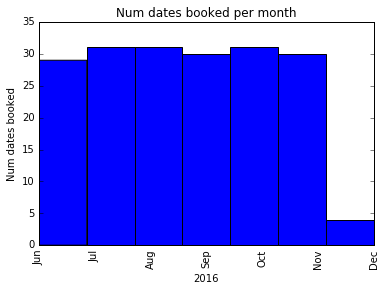

In [13]:
# I'm doing a histogram of num days / month which have been booked,
# as otherwise we end up with 186 datapoints, all of which have
# y-axis values of 1.

listing_months_booked = listing_dates_booked.apply(lambda dt : dt.month)
# Of course we could do this (more or less) with Pandas' visualisation
# e.g. listing_months_booked.hist(). However by way of an exercise, 
# am using pyplot directly.
xticklabels = [calendar.month_abbr[month] for month in listing_months_booked.unique()]
plt.title('Num dates booked per month')
plt.xticks(listing_months_booked.unique(), xticklabels, rotation=90)
plt.xlabel("2016")
plt.ylabel("Num dates booked")
plt.gca().xaxis.set_ticks_position('none') 
plt.hist(listing_months_booked.values, bins=len(xticklabels))
plt.show()

3\. Add to your figure a histogram of the dates which have not been booked.

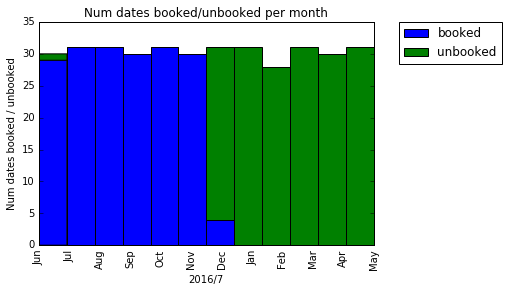

In [14]:
# One upshot of the decision to explicitly plot integer (rather than datetime64)
# values - for the months on the x-axis - is that plt.hist() will implicitly
# order them to run from 1 to 12. However 1 is Jan 2017, and 12 is Dec 2016, 
# so we need some way to handle the wrap-around. (I tried using 
# bins=[6,7,8,9,10,11,12,1,2,3,4,5] - but pyplot enforces a monotonically 
# increasing sequence.) Anyways, I'm just hacking it so that e.g. Jan 2017
# is month 13 (rather than 1).
listing_months_unbooked = listing_dates_unbooked.apply(
    lambda dt : 12 + dt.month if dt.month < 6 else dt.month)

# Construct a complete list of booked and unbooked months, for the x-axis values. 
listing_months = sorted(listing_months_booked.append(listing_months_unbooked).unique())

# And now I have to handle my artifical months 13 to 17, when generating
# the labels.
xticklabels = [calendar.month_abbr[month] if month < 13 
    else calendar.month_abbr[month-12] for month in listing_months]

# With that out of the way, the plotting bit is easy..
plt.title('Num dates booked/unbooked per month')
plt.xticks(listing_months, xticklabels, rotation=90)
plt.xlabel("2016/7")
plt.ylabel("Num dates booked / unbooked")
plt.gca().xaxis.set_ticks_position('none') 
# I'm stacking these on top of each other, as it gives a better 
# comparison between booked and unbooked. Although it did initially
# catch me out that e.g. December did not somehow have 35 days
# in it (i.e. the green bar for Dec doesn't start at the origin)
plt.hist([listing_months_booked, listing_months_unbooked], 
    stacked=True, bins=len(xticklabels), label=["booked", "unbooked"], rwidth=1)
plt.legend(bbox_to_anchor=(1.4, 1.025)) #thanks to stackoverflow for bbox_to_anchor hack..
plt.show()

## Part C

1\. Plot the average price for 10 random listings in your data.

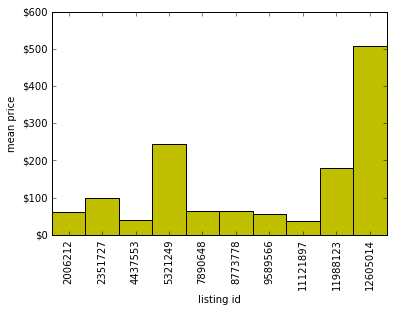

In [15]:
# Note I'm interpeting the question as "plot the average price for [each of] 10 random 
# listings in your data"

# Strictly speaking, we don't need to process the entire calendar for this question, 
# but it will come in handy later. Am using groupby for aggregation of the mean price.
average_prices = listings_calendar[['listing_id','price']].groupby(
    'listing_id', as_index=False).mean() 

average_prices.rename(columns={'price':'mean'}, inplace=True)

# Now get a random sample of listings (using known random_state so can replicate results)
ten_random_listings = average_prices.sample(10, random_state=random_seed) 
ten_random_listings = ten_random_listings.sort_values(by="listing_id")

# Plot the results. We could do boxplot, but Q3 below suggests a bar chart,
# since a boxplot would have already given us the std deviations.

# defining some functions for later re-use
def format_decimal(ax):
    ax.set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: '$' + str(Decimal(x))))
    
def plot_means(dataframe, col_x, col_y, col_std=None):
    numx = np.arange(len(dataframe))
    x = np.array(dataframe[col_x])
    y = dataframe[col_y]
    figure, ax = plt.subplots(1,1)
    ax.set_xticks(numx)
    ax.set_xticklabels(dataframe[col_x], rotation='vertical')
    format_decimal(ax.yaxis)
    if col_std is not None:
        stddev = dataframe[col_std]
        ax.bar(numx, y, 1, color='y', align='center', yerr=stddev)
    else:
        ax.bar(numx, y, 1, color='y', align='center')
    plt.xlabel('listing id')
    plt.ylabel('mean price')
    plt.show()

# Now do the plot
plot_means(ten_random_listings, 'listing_id', 'mean')

2\. Find the listings which vary their price depending on the date. How many do you have in your dataset? 

In [16]:
# Note I'm assuming that "your dataset" means the entire listings calendar,
# not just the 10 random listings above.

# Similarly, am using groupby to get the aggregate std.
stddevs = listings_calendar[['listing_id','price']].groupby('listing_id').std()
stddevs.rename(columns={'price':'stddev'}, inplace=True)

# Seem to have tripped across a bug (?) in groupby here, in that if we use
# as_index=False then we get garbage in our listing_id column. unstack
# doesn't help, since we get a Series not a DataFrame - but since we know
# that both stddevs and average_prices have the same size and the same
# ordering, we can just borrow the ids from average_prices.
stddevs['listing_id'] = average_prices['listing_id'].values

# Merge the mean and std values so now we have basic descriptives 
# per listing_id. Of course we could have done this in a single step,
# earlier, using describe() instead of mean() and std(). However that
# was painfully slow when I tried it.
descriptives = average_prices.merge(stddevs)

# Now we can print our answer. If the price doesn't vary, stddev will
# be zero, so we want the ones where it isn't.
print ('Number of listings which vary their price: %d' 
    % (len(descriptives[descriptives['stddev'] != 0])))


Number of listings which vary their price: 25623


3\. Now modify your plot from step 1 to illustrate the standard deviation of the prices in your figure

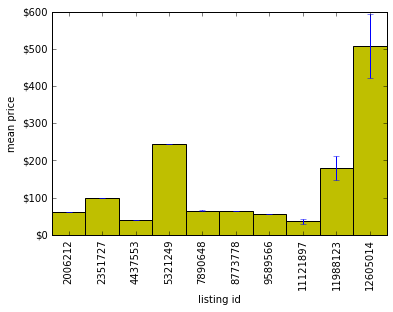

In [17]:
if not 'stddev' in ten_random_listings.columns: # so can re-run cell without adding duplicate cols
    ten_random_listings = ten_random_listings.merge(descriptives, on='listing_id')

plot_means(ten_random_listings, 'listing_id', 'mean_x', 'stddev')

4\. Plot the average price (including standard deviation) of all the listings which have a standard deviation greater than 0 in your data

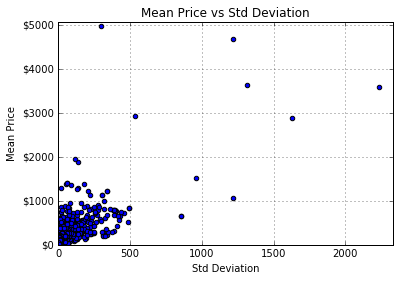

In [18]:
# Again, I'm assuming that this question relates to the entire listings 
# calendar, not just to the 10 random listings in Q1 & Q3 above
 
# Taken at face value, this question asks for a plot of the mean and 
# stddev of 25623 data points. Rather than a page full of bar charts, 
# or some xlim zooming, I've opted for a scatterplot of mean vs
# stddev - which does *literally* what the question asks, even if the 
# chart isn't remotely readable (!)

# Note that there are some genuine outliers here, e.g. listing 11336658
# really does have prices than vary between $50 and $5000 (giving a std
# deviation of $2231.89. Presumably this is duff data (see also min nightly
# price of $7.00, earlier).

listings_with_nonzero_std = descriptives[descriptives['stddev'] > 0]
plt.figure()    
ax = plt.gca()
ax.set_title('Mean Price vs Std Deviation')
ax.set_xlabel('Std Deviation')
ax.set_ylabel('Mean Price')
ax.set_xlim(0, listings_with_nonzero_std['stddev'].max() + 100)
ax.set_ylim(0, listings_with_nonzero_std['mean'].max() + 100)
format_decimal(ax.yaxis)
plt.grid()
plt.scatter(
    x=listings_with_nonzero_std['stddev'], 
    y=listings_with_nonzero_std['mean']
)
plt.show()


## Part D

Plot the average price of listings over neighbourhoods and room types. Note, you can have several plots to illustrate this information.

In [19]:
# Am first merging the neighbourhood and room_type columns from the
# original listings file (with some additional bells and whistles) with the
# descriptives dataframe which we constructed earlier. The latter contains
# mean and stddev per listing, and we can join listing_id to id.

listings_columns_to_merge = ['id','neighbourhood','room_type','latitude','longitude']

listings_descriptives = descriptives.merge(
    listings[listings_columns_to_merge],left_on='listing_id', right_on="id")

listings_descriptives.head()

,listing_id,mean,stddev,id,neighbourhood,room_type,latitude,longitude
0,8795,60.000000,0.00000,8795,Croydon,Entire home/apt,51.380145,-0.098818
1,9293,150.000000,0.00000,9293,Kensington and Chelsea,Entire home/apt,51.482968,-0.174777
2,9554,34.682657,2.70028,9554,Haringey,Private room,51.587767,-0.105666
3,11076,70.000000,0.00000,11076,Ealing,Private room,51.515645,-0.314508
4,11417,105.000000,0.00000,11417,Tower Hamlets,Entire home/apt,51.505887,-0.069901


In [20]:
# groupby seems the easiest way to do this, if not necessarily resulting in 
# the most user-friendly data structure (hierarchical indexes etc). 

mean_by_hood_and_room_type = listings_descriptives[
    ['neighbourhood','room_type','mean']].groupby(['neighbourhood','room_type']).mean()

# Unstacking makes it easier to pull out the data
mean_by_hood_and_room_type = mean_by_hood_and_room_type.unstack()
mean_by_hood_and_room_type.head()

mean                         
room_type            Entire home/apt Private room Shared room
neighbourhood                                                
Barking and Dagenham       69.441279    39.769896   18.789106
Barnet                    125.905454    45.137774   35.505615
Bexley                     77.436369    32.958202   36.712329
Brent                     116.455324    65.089568   25.749510
Bromley                   105.716535    43.562626   23.550930

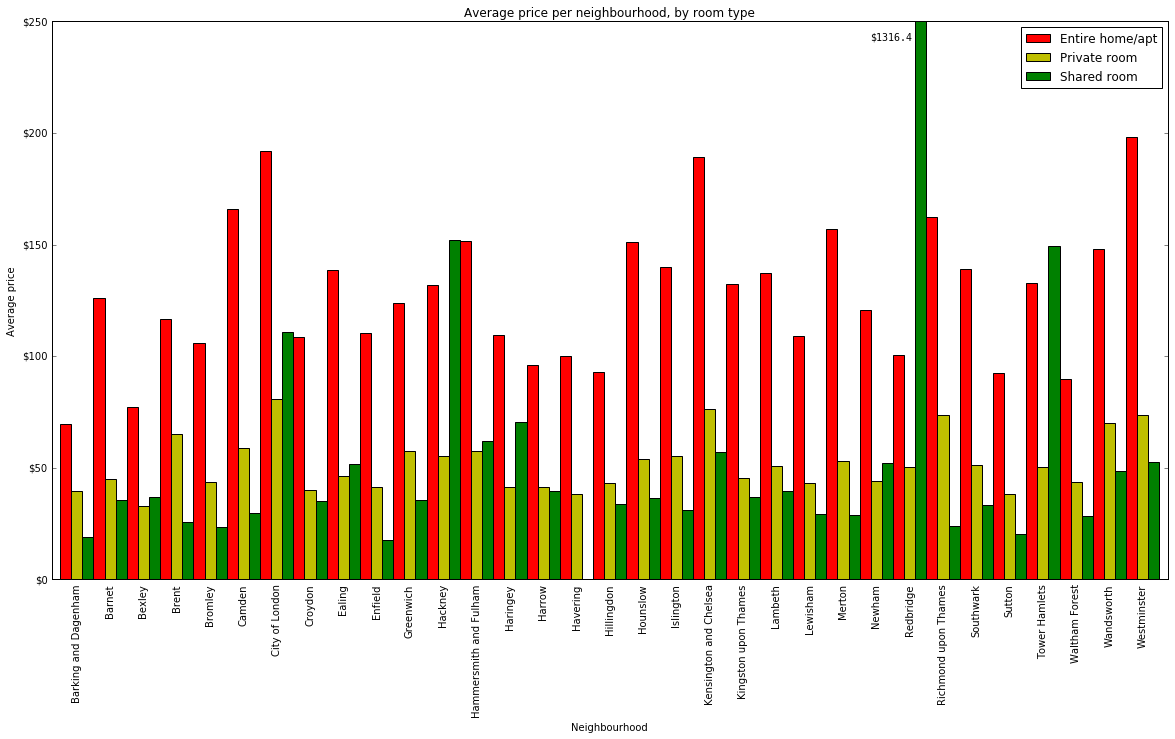

In [21]:
# Regards plotting, first there's the "easy" way - using Pandas' default visualisation
df_for_pandas_visualisation = pd.DataFrame(mean_by_hood_and_room_type.values, 
    index=mean_by_hood_and_room_type.index.values, 
            columns=mean_by_hood_and_room_type.mean().index.levels[1].values)

figure, ax = plt.subplots(1,1, figsize=(20,10))
format_decimal(ax.yaxis)
df_for_pandas_visualisation.plot(kind='bar', ax=ax, width=1.0, color=['r','y','g'])
plt.gca().xaxis.set_ticks_position('none') 

# Looks like some duff data for "Redbridge/Shared room" combo, so am zooming in 
# on the rest of the data and annotating the actual figure we can't see.
redbridge_max = '$' + str(mean_by_hood_and_room_type.ix['Redbridge']['mean'].max())
plt.gca().text(23.8, 242,redbridge_max, family='monospace', fontsize=10) 
plt.ylabel('Average price')
plt.xlabel('Neighbourhood')
plt.title('Average price per neighbourhood, by room type')
plt.gca().set_ylim(0, 250) 
plt.show()

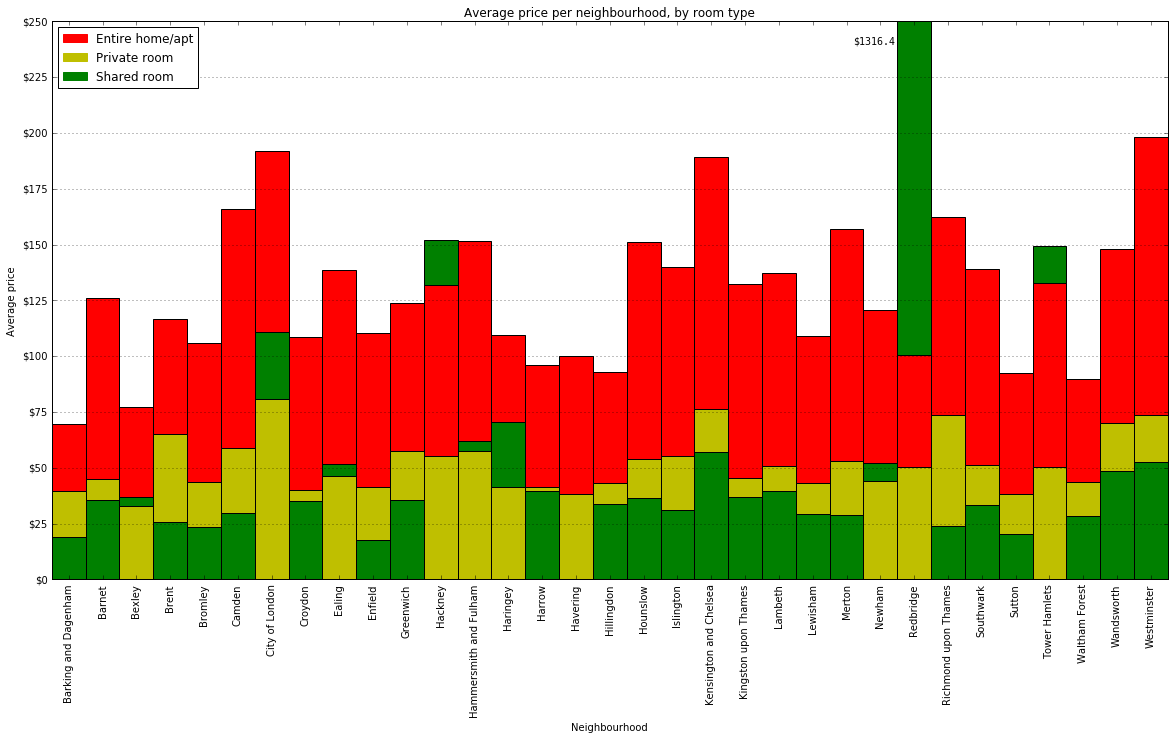

In [22]:
# And then there's the more difficult, but more flexible way,
# using matplotlib directly

# First structure the data from the groupby into a more accessible 
# format for plotting (just a basic np.array, ultimately)
neighbourhoods = sorted(listings['neighbourhood'].unique())
room_types = sorted(listings['room_type'].unique())
mean_by_hood = []
for neighbourhood in neighbourhoods:
    mean_by_room_type = []
    for room_type in room_types:
        mean = mean_by_hood_and_room_type.ix[neighbourhood]['mean'][room_type];
        mean_by_room_type.append(mean)
    mean_by_hood.append(mean_by_room_type)
x = np.array(mean_by_hood)
x = np.nan_to_num(x) #not all hoods have all room types

# Now we can plot
colors=['r','y','g']
numx=np.arange(len(neighbourhoods))
figure, ax = plt.subplots(1,1, figsize=(20,10))
ax.set_xticks(numx)
ax.set_xticklabels(neighbourhoods, rotation='vertical')
format_decimal(ax.yaxis)

# However..
# An issue with just plotting a bar chart for each room type in turn, is that 
# there is no consistent relationship between them in terms of which has the max
# mean price. So for Redbridge, for example, the mean "Shared room" price is higher
# than the mean "Entire home/apt" price - vs pretty much all other boroughs, where
# the opposite is true. Matplotlib doesn't seem to handle this automatically (?)
# so we end up with the other two rooms types for Redbridge (for example) being
# hidden behind the big green bar. (I'm wanting to "stack" these by design, btw -
# rather than plotting three small bars for each neighbourhood like in the default
# example above.)
# 
# Using stacked=True doesn't seem like an option, as stacked bars don't then 
# start at the origin (the mean price for a stacked bar becomes y2-y1, which
# isn't easy to discern from the chart).There may be a way to configure these issues 
# away, however I've opted to plot each bar indivdually for each neighbourhood, in 
# order of decreasing mean price. So there are actually 33 * 3 calls to ax.bar(..)
# in the loop below - which is not especially efficient, but does have the desired
# effect.

for i in range(len(room_types)):
    for j in range(len(neighbourhoods)):
        max_mean = x[j].max()
        room_type = np.where(x[j] == max_mean)[0][0]
        x[j][room_type] = 0.
        spam = np.zeros(len(neighbourhoods))
        spam[j] = max_mean
        ax.bar(numx, spam, 1, color=colors[room_type], align='center', label=room_types[room_type])
        
# borrowed this from http://matplotlib.org/users/legend_guide.html        
r_patch = mpatches.Patch(color=colors[0], label=room_types[0])
y_patch = mpatches.Patch(color=colors[1], label=room_types[1])
g_patch = mpatches.Patch(color=colors[2], label=room_types[2])
plt.legend(handles=[r_patch, y_patch, g_patch], loc=2)
# end

# zoom in again to stop our Redbridge outlier from dwarfing the scale
plt.gca().text(23.2, 240,redbridge_max, family='monospace', fontsize=10) 
plt.gca().set_ylim(0, 250) 

# tick lines are useful, on the y-axis
plt.yticks(np.arange(0, 275, 25))
plt.gca().yaxis.grid(which='both')
plt.ylabel('Average price')
plt.xlabel('Neighbourhood')
plt.title('Average price per neighbourhood, by room type')
plt.show()
    

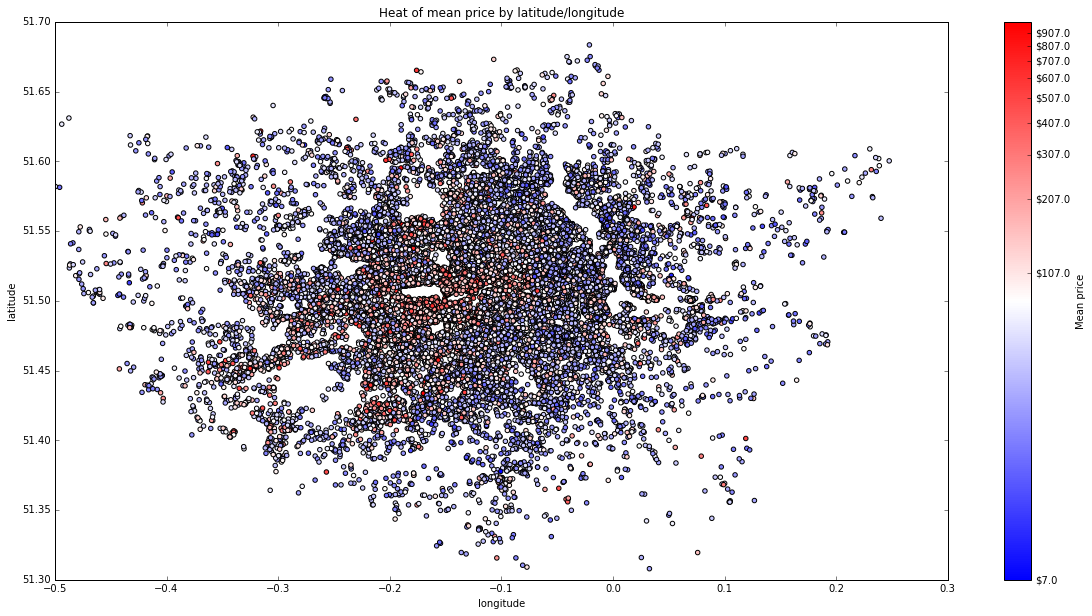

In [23]:
# Also there's fun with heatmaps.. 
fig = plt.figure(figsize=(20,10))    
ax = fig.add_subplot(111)
ax.set_title('Heat of mean price by latitude/longitude')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
# Am filtering out the 58 listings with mean > 1000 to aid the colormap visualisation
heatmap_listings = listings_descriptives[(listings_descriptives['mean'] < 1000)]
min_mean=heatmap_listings['mean'].min()
max_mean=heatmap_listings['mean'].max()
plt.gca().set_xlim(-0.5, 0.3) 
plt.gca().set_ylim(51.3, 51.7) 
norm=matplotlib.colors.LogNorm(vmin=min_mean, vmax=max_mean)
plt.scatter(
    x=heatmap_listings['longitude'], 
    y=heatmap_listings['latitude'],
    c=heatmap_listings['mean'],
    cmap=plt.cm.bwr,
    norm=norm
)

bar = plt.colorbar(norm=None)
bar_ticks = np.arange(min_mean, max_mean, 100)
bar_ticklabels = ['$' + str(bar_tick) for bar_tick in bar_ticks]
bar.set_label("Mean price")
bar.set_ticks(bar_ticks)
bar.set_ticklabels(bar_ticklabels)
plt.show()